### HitzeExpositionsIndex (HEI)

**Datenquelle:** DWD Rasterdaten – tägliche maximale Lufttemperatur (daily Tmax) auf Rasterbasis.  
**Zeitraum:** Sommer (Mai–September) 2019-2023.

- $g\in G$ Gemeinde
- $y\in Y$ betrachtetes Jahr ($Y=\{2019,\ldots,2023\}$)

**Grundgrößen je Gemeinde $g\in G$:**
- $H35_{g,y}$ : Anzahl Tage mit Gemeinde-Flächenmittel $T_{\max} > 35^\circ\text{C}$ im Sommer von Jahr $y$.
- $I30_{g,y} = \sum_{\text{Sommer-Tage } d} \max\{0, T_{\max,g,d} - 30^\circ\text{C}\}$ (Einheit: °C·Tage).

$I30$ gewichtet die Tage mit hoher Abweichung von 30°C höher, während $H35$ die Anzahl Tage über 35°C beschreibt.

**Jahresfenster-Mittelwerte:**
$$
\overline{H35}_g \;=\; \frac{1}{|Y|}\sum_{y\in Y} H35_{g,y}, \qquad
\overline{I30}_g \;=\; \frac{1}{|Y|}\sum_{y\in Y} I30_{g,y}.
$$

**Robuste Standardisierung über alle Gemeinden $g\in G$:**
$$
z_r(x_g) \;=\; \frac{x_g - \operatorname{median}_{h\in G}(x_h)}
{1.4826 \cdot \operatorname{median}_{h\in G}\!\bigl(|x_h - \operatorname{median}_{j\in G}(x_j)|\bigr)}.
$$
*(Optional: $z_r$ bei $\pm 3$ winsorizen statt abschneiden.)*

**Kombination (Modelldesign):**
$$
\mathrm{HEI}_{\text{raw}}(g) \;=\; 0.6\, z_r\bigl(\overline{I30}_g\bigr) \;+\; 0.4\, z_r\bigl(\overline{H35}_g\bigr).
$$

**Robustes 0–100-Scaling (p1/p99-Clipping):**
$$
p_1 = \operatorname{perc}_{1\%}\!\bigl(\mathrm{HEI}_{\text{raw}}(h)\bigr),\quad
p_{99} = \operatorname{perc}_{99\%}\!\bigl(\mathrm{HEI}_{\text{raw}}(h)\bigr),
$$
$$
\mathrm{HEI}(g) \;=\; 100 \cdot 
\min\!\left\{1,\ \max\!\left\{0,\ \frac{\mathrm{HEI}_{\text{raw}}(g) - p_1}{\,p_{99} - p_1\,}\right\}\right\}.
$$


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import choropleth_pipeline as cp

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, TwoSlopeNorm

In [2]:
vals2023 = pd.read_parquet(f"cache/hitze_metrics_gem_year_2023.parquet")
vals2022 = pd.read_parquet(f"cache/hitze_metrics_gem_year_2022.parquet")
vals2021 = pd.read_parquet(f"cache/hitze_metrics_gem_year_2021.parquet")
vals2020 = pd.read_parquet(f"cache/hitze_metrics_gem_year_2020.parquet")
vals2019 = pd.read_parquet(f"cache/hitze_metrics_gem_year_2019.parquet")

val_list = [vals2023,vals2022,vals2021,vals2020,vals2019]

In [3]:
df = pd.concat(val_list)
df.columns

Index(['year', 'ARS', 'H30', 'H32', 'H35', 'I30', 'H30_any', 'H32_any',
       'H35_any', 'H30_frac10', 'H32_frac10', 'H35_frac10', 'D30'],
      dtype='object')

In [4]:
# Daten aggregieren (mitteln)
agg = (df.groupby('ARS')
       .agg(
           H30_mean = ("H30", "mean"),
           H32_mean = ("H32", "mean"),
           H35_mean = ("H35", "mean"),
           I30_mean = ("I30", "mean"),
       )
       .reset_index()
      ).copy()


In [6]:
# z-Transform für alle numerischen Spalten anwenden
for col in ["H30_mean","H32_mean","H35_mean","I30_mean"]:
        agg[col + "_z"] = cp.robust_z(agg[col])

agg.head()

,ARS,H30_mean,H32_mean,H35_mean,I30_mean,H30_mean_z,H32_mean_z,H35_mean_z,I30_mean_z
0,010010000000,0.6,0.4,0.0,1.120000,-1.904444,-1.498868,-0.899321,-1.555969
1,010020000000,1.4,0.4,0.2,2.526989,-1.745741,-1.498868,-0.674491,-1.450920
2,010030000000,2.8,0.6,0.2,5.411112,-1.468009,-1.423925,-0.674491,-1.235584
3,010040000000,4.8,1.0,0.2,6.529093,-1.071250,-1.274038,-0.674491,-1.152112
4,010510011011,5.6,2.4,0.2,11.306049,-0.912546,-0.749434,-0.674491,-0.795452


In [7]:
# Index berechnen aus Intensität und extrem-Hitze
agg['Index_raw'] = 0.6*agg['I30_mean_z'] + 0.4*agg['H35_mean_z']
agg.head()

,ARS,H30_mean,H32_mean,H35_mean,I30_mean,H30_mean_z,H32_mean_z,H35_mean_z,I30_mean_z,Index_raw
0,010010000000,0.6,0.4,0.0,1.120000,-1.904444,-1.498868,-0.899321,-1.555969,-1.293310
1,010020000000,1.4,0.4,0.2,2.526989,-1.745741,-1.498868,-0.674491,-1.450920,-1.140348
2,010030000000,2.8,0.6,0.2,5.411112,-1.468009,-1.423925,-0.674491,-1.235584,-1.011147
3,010040000000,4.8,1.0,0.2,6.529093,-1.071250,-1.274038,-0.674491,-1.152112,-0.961064
4,010510011011,5.6,2.4,0.2,11.306049,-0.912546,-0.749434,-0.674491,-0.795452,-0.747068


In [8]:
# zur besseren Darstellung auf 0-100 skalieren (entspricht % Wert)
agg["Index_0_100"] = cp.scale_0_100((agg["Index_raw"],1, 99)

### Zusatz: Stabilitäts-Layer zum HEI

**Zweck:** Die folgenden Layer beschreiben die **Jahres-zu-Jahres-Stabilität** der Hitzeexposition im gewählten Zeitfenster $Y$ (z. B. 2020–2024). Sie quantifizieren, ob hohe HEI-Werte **dauerhaft** oder eher **wettergetrieben volatil** sind.

**Definitionen (je Gemeinde $g$):**
- **I30_std** – Standardabweichung der jährlichen $I30_{g,y}$ im Fenster $Y$ (Einheit: °C·Tage).  
  Misst die **absolute Streuung** der Intensität.
- **H35_std** – Standardabweichung der jährlichen $H35_{g,y}$ (Einheit: Tage).  
  Misst die **absolute Streuung** extremer Hitzetage.
- **I30_cv** – Variationskoeffizient $=\ \dfrac{\mathrm{std}(I30_{g,y})}{\mathrm{mean}(I30_{g,y})}$ (dimensionslos).  
  **Relative Volatilität** der Intensität.
- **H35_cv** – Variationskoeffizient für $H35$ analog (dimensionslos).  
  **Relative Volatilität** extremer Hitzetage.

**Interpretation (Daumenregeln):**
- **STD:** groß ⇒ starke **absolute** Schwankungen (mehr °C·Tage bzw. Tage Unterschied zwischen Jahren).  
- **CV:**  
  - $< 0.3$ ⇒ **stabil** (HEI wird durch dauerhafte Muster getragen),  
  - $0.3$–$0.6$ ⇒ **moderat variabel**,  
  - $> 0.6$ ⇒ **volatil** (HEI stark wetter-/jahrgangsgetrieben).  
  *Hinweis:* Bei sehr kleinen Mittelwerten kann der CV erratisch werden.

**Nutzung in Karten/Analysen:**
- **Unsicherheits-Overlay:** Regionen mit hohem **CV** semitransparent darstellen oder kennzeichnen.  
- **Qualitätsfilter:** z. B. nur Gemeinden mit **I30_cv ≤ 0.6** für harte Vergleiche heranziehen.  
- **Diagnose:** „I30-dominiert“ vs. „H35-dominiert“ lässt sich mit den jeweiligen **cv/std** schnell erkennen.

**Wichtig:** Die Stabilitätsmaße gelten **nur für dasselbe Zeitfenster $Y$** wie der HEI und setzen **genügend Jahre** voraus (z. B. mindestens 3 in einem 5-Jahres-Fenster).


In [9]:
# Layer für den Beitrag I30 vs H35
contrib_I30 = 0.85 * agg["I30_mean_z"]
contrib_H35 = 0.15 * agg["H35_mean_z"]
share_I30 = (contrib_I30 / (contrib_I30.abs() + contrib_H35.abs())).fillna(0)
agg["HEI_driver"] = np.where(share_I30 >= 0.5, "I30-dominiert", "H35-dominiert")

In [10]:
# Stabilität 
stab = (df
        .groupby("ARS", as_index = False)
        .agg(I30_std=("I30","std"), I30_mean=("I30","mean"),
             H32_std=("H32","std"), H32_mean=("H32","mean"),
             H35_std=("H35","std"), H35_mean=("H35","mean"))
       )
stab["I30_cv"] = (stab["I30_std"] / stab["I30_mean"]).replace([np.inf, np.nan], 0)
stab["H32_cv"] = (stab["H32_std"] / stab["H32_mean"]).replace([np.inf, np.nan], 0)
stab["H35_cv"] = (stab["H35_std"] / stab["H35_mean"]).replace([np.inf, np.nan], 0)

agg = agg.merge(
    stab[['ARS', 'I30_std', 'H32_std','H35_std', 'I30_cv', 'H32_cv','H35_cv']],
    on = 'ARS',
    how = 'inner'
)



### Speichern der Werte (ohne Geometrie)

In [11]:
agg.to_csv('HitzeExpositionsIndex_2023.csv', index = False)

### Geometrie laden

In [12]:
VG250_GPKG = "../geometry/DE_VG250.gpkg"

# Geographie-daten laden
# ARS = Amtlicher Regionalschlüssel
vg = cp.VG250Spec(gpkg_path=VG250_GPKG, id_col = "ARS")

# Geometrien für Plot laden
gemeinden = cp.load_level(vg, "GEM")
laender = cp.load_level(vg, 'LAN')

gdf = gemeinden.merge(agg, on = 'ARS', how='inner')
gdf.shape

(10957, 43)

### Plotten der Ergebnislayer

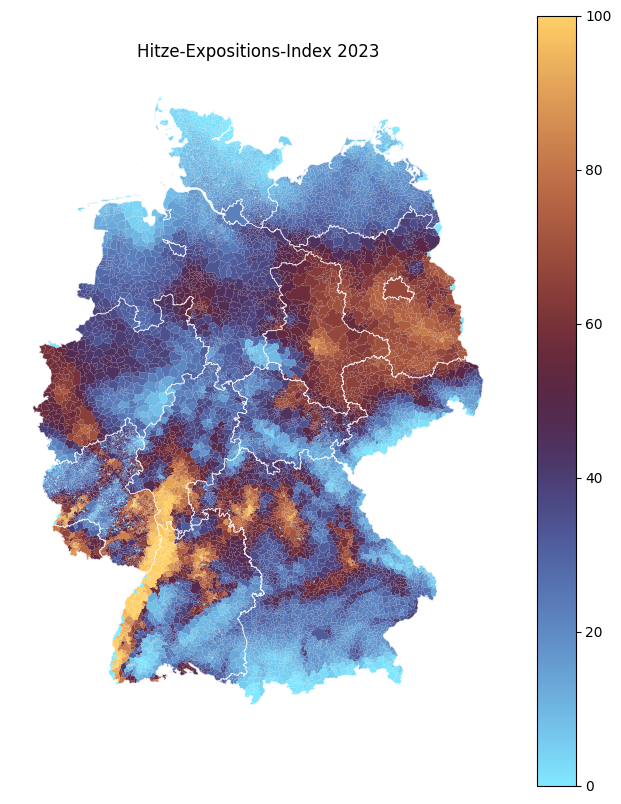

In [13]:
# plots with a view
fig, ax = cp.plot_choropleth_continuous(
    gdf,
    value_col=f'Index_0_100',
    cmap_name="managua_r",          
    title=f"Hitze-Expositions-Index 2023",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=50, vmax=100) 
)

# Speichern
out_file = cp.save_map(
    fig, 
    filename=f"HEI_2023.png", 
    out_dir="exports",
    dpi=300
)

---

### Statistische Betrachtungen

(<Figure size 800x1000 with 2 Axes>,
 <Axes: title={'center': 'Coefficient of Variation für I30'}>)

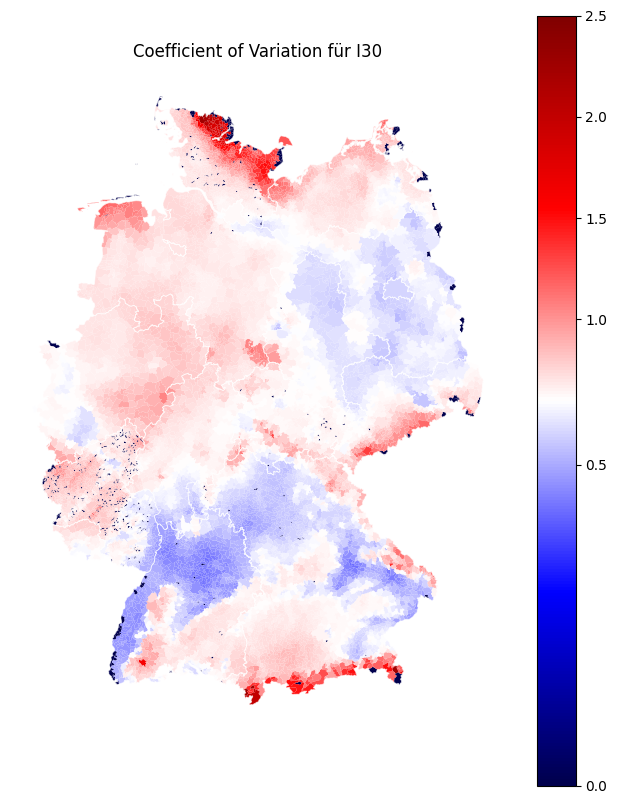

In [14]:
cp.plot_choropleth_continuous(
    gdf,
    value_col=f'I30_cv',
    cmap_name="seismic",          
    title=f"Coefficient of Variation für I30",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=0.6, vmax=2.5) 
)

(<Figure size 800x1000 with 2 Axes>,
 <Axes: title={'center': 'Coefficient of Variation für H32'}>)

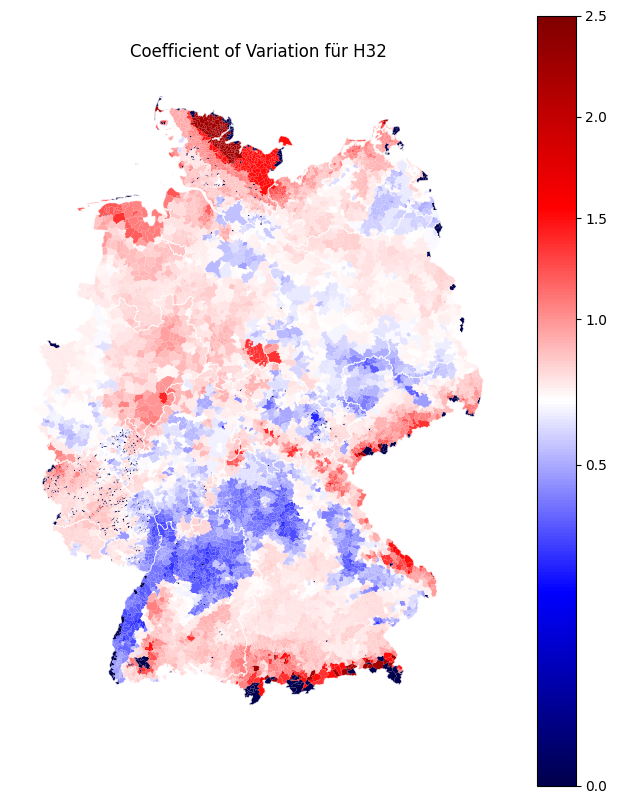

In [15]:
cp.plot_choropleth_continuous(
    gdf,
    value_col=f'H32_cv',
    cmap_name="seismic",          
    title=f"Coefficient of Variation für H32",
    laender = laender,
    figsize=(8, 10),
    norm = TwoSlopeNorm(vmin=0, vcenter=0.6, vmax=2.5) 
)

In [16]:
# Redundanz von H35 berechnen nach Spearman
rho = agg['I30_mean_z'].corr(agg['H32_mean_z'], method = "spearman")

# >0.8: H35 weitgehend redundant
rho

np.float64(0.990359188617306)

In [17]:
# Residual Quote
X = agg["I30_mean_z"].to_numpy(); Y = agg["H35_mean_z"].to_numpy()
beta = np.cov(X, Y, ddof=1)[0,1] / np.var(X, ddof=1)   # Regressionssteigung H35~I30
res  = Y - beta*X
unique_ratio = np.nanstd(res, ddof=1) / np.nanstd(Y, ddof=1)
print("H35-Unique-Ratio =", unique_ratio)  # <0.3 ⇒ wenig Eigen-Signal

# <0.3 ⇒ wenig Eigen-Signal

H35-Unique-Ratio = 0.3764320817216687


In [18]:
# Kendall tau - Rangstabilität
hei_I   = 1.0*agg["I30_mean_z"]
hei_I35 = 0.6*agg["I30_mean_z"] + 0.4*agg["H35_mean_z"]  # deine aktuelle Mischung
tau = pd.Series(hei_I).corr(pd.Series(hei_I35), method="kendall")
print("Kendall τ(HEI_I vs HEI_I+H35) =", tau)  # ≥0.9 ⇒ H35 ändert Ranking kaum

# Wert über 0.9: ändert die Rangfolge kaum

Kendall τ(HEI_I vs HEI_I+H35) = 0.9137519838457765


In [19]:
k = max(1, int(0.10*len(agg)))
idx1 = set(agg.assign(s=hei_I).nlargest(k, "s").index)
idx2 = set(agg.assign(s=hei_I35).nlargest(k, "s").index)
jaccard = len(idx1 & idx2) / len(idx1 | idx2)
print("Top-Decile-Jaccard =", jaccard)  
# >0.8 ⇒ kaum neue Hotspots

Top-Decile-Jaccard = 0.8326359832635983


### Schlußfolgerung

H35 hat keinen signifikanten Einfluss und kann als Indikator für wetterbasiert vs langfristigere Einflüsse benutzt werden. Aber für den HitzeExpositionsindex spielt er kaum eine Rolle und kann daher niedriger gewichtet werden (0.85 $I30$ + 0.15 $H35$).